In [9]:
import numpy as np
import scipy.integrate
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
from keras import Input, Model, regularizers
from keras.datasets import mnist
from keras.layers import Dense, concatenate
import time
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
from keras.layers import Activation
from keras import backend as K
from keras.utils.generic_utils import get_custom_objects
from tensorflow.keras.losses import categorical_crossentropy, mean_squared_error
from tensorflow.keras.optimizers import Adam
import sys

In [10]:
def square_activation(x):
    return K.pow(x,2)

get_custom_objects().update({'square_activation': Activation(square_activation)})

def power_four_activation(x):
    return K.pow(x,4)
get_custom_objects().update({'power_four_activation': Activation(power_four_activation)})

def cos_activation(x):
    return K.cos(x)
get_custom_objects().update({'cos_activation': Activation(cos_activation)})

def sin_activation(x):
    return K.sin(x)
get_custom_objects().update({'sin_activation': Activation(sin_activation)})


In [11]:
def load_data(file_xtrain, file_ytrain):
    x_train = np.load(file_xtrain)
    y_train = np.load(file_ytrain)
    return x_train, y_train

In [12]:
#Load simulated data
x_train, y_train = load_data("data_for_pendulum/x_train_pendulum.npy","data_for_pendulum/y_train_pendulum.npy" )

In [24]:
#Build model
input_data = Input(shape=(2,))
first_layer = Dense(1, activation=cos_activation)(input_data[0,])
second_layer = Dense(4, activation=square_activation)(input_data)
concatenated_layer = concatenate([first_layer, second_layer])
new_layer = Dense(4, activation="linear")(concatenated_layer)
new_layer = Dense(1, activation="relu")(new_layer)
model_HNN = Model(input_data, new_layer)
opt = Adam()

def step(X, y):
    x = tf.Variable(X,dtype="float32")

    with tf.GradientTape() as tape2:
        with tf.GradientTape() as tape1:
            H = model_HNN(x)
        dH = tape1.gradient(H, x)
        loss = mean_squared_error(dH,y)
    grads = tape2.gradient(loss, model_HNN.trainable_variables)
    opt.apply_gradients(zip(grads, model_HNN.trainable_variables))

ValueError: Input 0 of layer dense_11 is incompatible with the layer: : expected min_ndim=2, found ndim=1. Full shape received: [2]

In [14]:
EPOCHS = 1
BS = 1000
numUpdates = int(x_train.shape[0] / BS)
model_HNN.compile(optimizer=opt, loss=mean_squared_error,metrics=["acc"])

for epoch in range(0, EPOCHS):
    # show the current epoch number
    print("[INFO] starting epoch {}/{}...".format(
        epoch + 1, EPOCHS), end="")
    sys.stdout.flush()
    epochStart = time.time()
    for i in tqdm(range(0, numUpdates)):
        # determine starting and ending slice indexes for the current
        # batch
       
        start = i * BS
        end = start + BS
        step(x_train[start:end], y_train[start:end])

[INFO] starting epoch 1/1...

In [15]:
xx = np.array([[555,50]])
xx = tf.Variable(xx,dtype="float32")
with tf.GradientTape() as tape1:
    pred = model_HNN(xx)
dh = tape1.gradient(pred, xx).numpy()
print(dh)

[[48.605618 60.56075 ]]


In [16]:
def RHS_from_ODE(t,x):
    x = x[None,:]
    xx = tf.Variable(x,dtype="float32")
    with tf.GradientTape() as tape1:
        pred = model_HNN(xx)
    dh = tape1.gradient(pred, xx).numpy()[0,:]
    res = [dh[1], - dh[0]]
    
    return res

In [17]:
# def evaluate_gradient(x):
#     x = x[None,:]
#     xx = tf.Variable(x,dtype="float32")
#     with tf.GradientTape() as tape1:
#         pred = model_HNN(xx)
#     dh = tape1.gradient(pred, xx).numpy()[0,:] 
#     return dh
# def integrate_euler_symplectic_scheme(n_steps,dt,x0):
#     result = np.zeros((2,n_steps))
#     result[:,0] = x0
#     for i in tqdm(range(1,n_steps)):
        
#         dh = evaluate_gradient(result[:,i-1])
        
#         result[1,i] = result[1,i-1] - dh[0]*dt
#         dh = evaluate_gradient(result[:,i])
        
#         result[0,i] = result[0,i-1] + dh[1]*dt
        
#     return result
    

In [18]:
x0=np.array([5.,3.])
tspan=np.linspace(0,100,10000)
nsteps = tspan.size
dt = np.diff(tspan)[0]
# yy=integrate_euler_symplectic_scheme(nsteps, dt, x0)

In [19]:
g=9.8
L=1
m=1
def func( t, y ):
    global g,L

    return [ y[1]/(m*L**2), -g*m*L*2 * np.sin( y[0] ) ]

In [20]:
res = scipy.integrate.solve_ivp(fun = RHS_from_ODE,  y0=x0, t_span = [tspan.min(),tspan.max()], t_eval= tspan)
true_sol = scipy.integrate.solve_ivp(fun = func,  y0=x0, t_span = [tspan.min(),tspan.max()], t_eval= tspan)

<IPython.core.display.Javascript object>


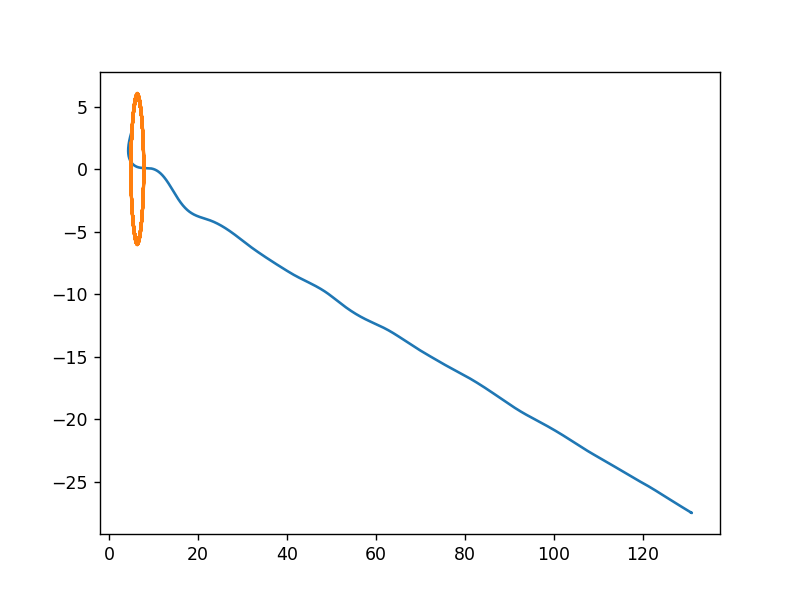

In [23]:
plt.figure()
plt.plot(res.y[0,:],res.y[1,:])
plt.plot(true_sol.y[0,:],true_sol.y[1,:])

In [22]:
%matplotlib notebook